## Sample 6.2 Multi-parameter Bayesian model: Globular cluster membership

In [20]:
%matplotlib inline
#%pylab
#posteior distribution of normal data
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import matplotlib
matplotlib.rc('xtick', labelsize=12) 
matplotlib.rc('ytick', labelsize=12) 
from astropy.table import Table
import emcee
import corner

gc = Table.read("N6205.vot",format="votable")


In [21]:
print(gc[0])

    solution_id             designation               source_id      random_index ref_epoch         ra              ra_error             dec            dec_error           parallax        parallax_error   parallax_over_error        pmra           pmra_error            pmdec           pmdec_error    ra_dec_corr ra_parallax_corr ra_pmra_corr ra_pmdec_corr dec_parallax_corr dec_pmra_corr dec_pmdec_corr parallax_pmra_corr parallax_pmdec_corr pmra_pmdec_corr astrometric_n_obs_al astrometric_n_obs_ac astrometric_n_good_obs_al astrometric_n_bad_obs_al astrometric_gof_al astrometric_chi2_al astrometric_excess_noise astrometric_excess_noise_sig astrometric_params_solved astrometric_primary_flag astrometric_weight_al astrometric_pseudo_colour astrometric_pseudo_colour_error mean_varpi_factor_al astrometric_matched_observations visibility_periods_used astrometric_sigma5d_max frame_rotator_object_type matched_observations duplicated_source phot_g_n_obs phot_g_mean_flux phot_g_mean_flux_error phot_

In [22]:
ind_gc = (gc['parallax_over_error']>3.) &\
    ( gc['parallax']>-0.03) & ( gc['parallax']<0.2)
print(np.sum(ind_gc))
ind_fld = (gc['parallax_over_error']>3.) &\
    ( gc['parallax']>-0.03) & ( gc['parallax']>=0.2)
print(np.sum(ind_fld))

466
9491


Text(0, 0.5, 'pm_DE')

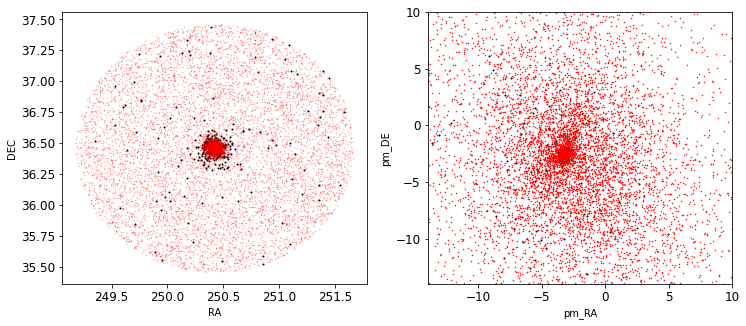

In [23]:
fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot(121)
ax.plot(gc['ra'][ind_gc],gc['dec'][ind_gc],'k.',markersize=2,alpha=1)
ax.plot(gc['ra'][ind_fld],gc['dec'][ind_fld],'r.',markersize=1,alpha=0.3)
ax.set_xlabel('RA')
ax.set_ylabel('DEC')

ax = fig.add_subplot(122)
ax.plot(gc['pmra'][ind_gc],gc['pmdec'][ind_gc],'k.',markersize=2,alpha=1)
ax.plot(gc['pmra'][ind_fld],gc['pmdec'][ind_fld],'r.',markersize=1,alpha=1)
ax.set_xlim(-14,10)
ax.set_ylim(-14,10)
ax.set_xlabel('pm_RA')
ax.set_ylabel('pm_DE')

In [24]:
ind_gc2 = ind_gc & (gc['pmra']>-4) & (gc['pmra']<-2.5) & (gc['pmdec']>-3) & (gc['pmdec']<-1.7)

Text(0.5, 0, 'parallax')

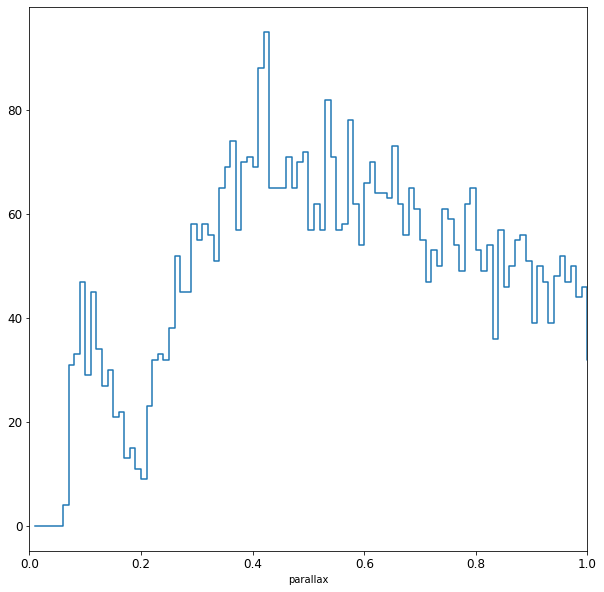

In [25]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
h,xedge = np.histogram(gc['parallax'][ind_gc2 | ind_fld],np.arange(0,5,0.01))
ax.step(xedge[1:],h,where='post')
ax.set_xlim(0,1)
ax.set_xlabel('parallax')

Text(0, 0.5, '$\\mu_{DEC}$')

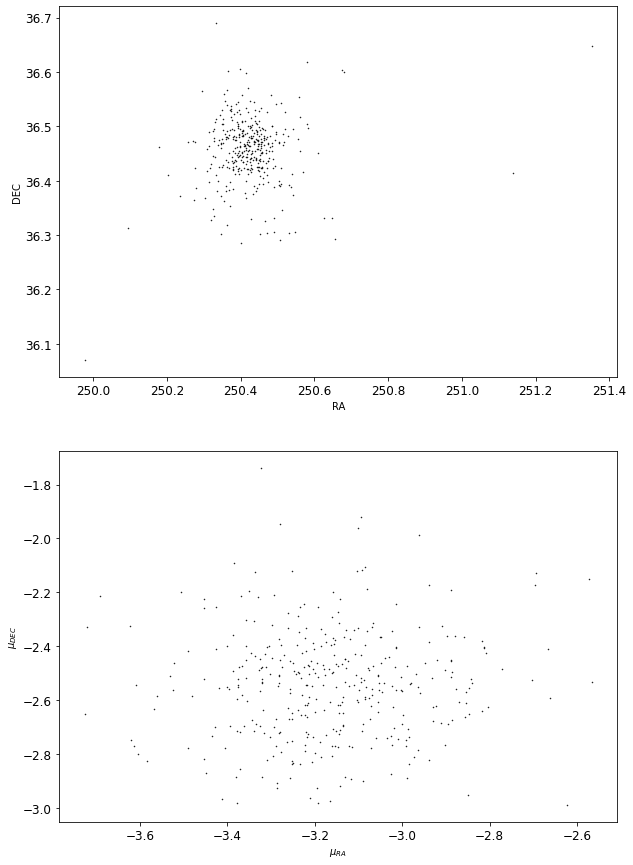

In [26]:
fig = plt.figure(figsize=(10,15))
ax = fig.add_subplot(211)
ax.plot(gc['ra'][ind_gc2],gc['dec'][ind_gc2],'k.',markersize=1)
#ax.plot(gc['ra'][ind_fld],gc['dec'][ind_fld],'r.',markersize=1,alpha=0.3)
ax.set_xlabel('RA')
ax.set_ylabel('DEC')

ax = fig.add_subplot(212)
ax.plot(gc['pmra'][ind_gc2],gc['pmdec'][ind_gc2],'k.',markersize=1)
#ax.plot(gc['pmra'][ind_fld],gc['pmdec'][ind_fld],'r.',markersize=1,alpha=0.3)
# ax.set_xlim(-4,-1)
# ax.set_ylim(-4,-1)
ax.set_xlabel(r'$\mu_{RA}$')
ax.set_ylabel(r'$\mu_{DEC}$')

## estimate the mean proper motions of N6205
## $p(\mu,\Sigma|y)\propto p(y|\mu,\Sigma)p(\mu)p(\sigma_\alpha)p(\sigma_\delta)=\frac{\exp(-{\mu}^T\Sigma^{-1}{\mu})}{2\pi\sigma_\alpha^3\sigma_\delta^3\sqrt{1-\rho^2}}$

(371, 2)
mean: [-3.16737656 -2.5426835 ]
std.: [0.1917202868654848 0.20031279592635934]


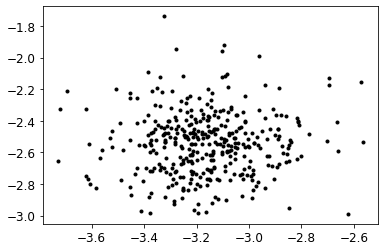

In [27]:
y = np.concatenate((gc['pmra'][ind_gc2].data.reshape(np.sum(ind_gc2),1),\
                    gc['pmdec'][ind_gc2].data.reshape(np.sum(ind_gc2),1)),axis=1)
print(y.shape)
print('mean:',np.mean(y,axis=0))
print('std.:',np.std(y,axis=0))
plt.plot(y[:,0],y[:,1],'k.')

In [28]:
def posterior1(theta,y):
    '''
    without 1/sigma**2 prior
    '''
    x = np.zeros_like(y)
    x[:,0] = y[:,0]-theta[0]
    x[:,1] = y[:,1]-theta[1]
    #print(np.mean(y,axis=0),np.mean(x,axis=0))
    s1 = theta[2]
    s2 = theta[3]
    rho = theta[4]
    if np.abs(rho)>1 or s1<=0 or s2<=0  :
        lnp = -1e50
    else:
        lnp = np.sum(-1./(2.*(1-rho**2))*(x[:,0]**2/s1**2-2*rho*x[:,0]*x[:,1]/(s1*s2)+x[:,1]**2/s2**2))-\
            (y.shape[0])*np.log(s1)-(y.shape[0])*np.log(s2)-0.5*y.shape[0]*np.log(1-rho**2)
    return lnp

def posterior2(theta,y):
    '''
    with 1/sigma**2 prior
    '''
    mu = np.zeros_like(y)
    mu[:,0] = y[:,0]-theta[0]
    mu[:,1] = y[:,1]-theta[1]
    s1 = theta[2]
    s2 = theta[3]
    rho = theta[4]
    if np.abs(rho)>1 or s1<=0 or s2<=0:
        lnp = -1e50
    else:
        lnp = np.sum(-1./(2.*(1-rho**2))*(mu[:,0]**2/s1**2-2*rho*mu[:,0]*mu[:,1]/(s1*s2)+mu[:,1]**2/s2**2))-\
            (2.+y.shape[0])*np.log(s1)-(2.+y.shape[0])*np.log(s2)-0.5*y.shape[0]*np.log(1-rho**2)
    return lnp

def mcmc_run(y, p0, lnlikeli = posterior1, ndim = 2, nwalkers = 50):
    

    sampler = emcee.EnsembleSampler(nwalkers, \
        ndim, lnlikeli, \
        args=[y])

    pos, prob, state = sampler.run_mcmc(p0, 100)
    sampler.reset()

    sampler.run_mcmc(pos, 1000)

    samples = sampler.chain[:, :, :].reshape((-1, ndim))
    return samples

    

In [29]:
## always test your ln posterior before MCMC
theta1= [-2.5,-2.5,0.2,0.3,0.]
print(posterior1(theta1,y),posterior2(theta1,y))
theta2= [-0.7,-0.1,0.2,0.3,0.]
print(posterior1(theta2,y),posterior2(theta2,y))

-1278.644274870396 -1273.0174534368757
-39740.27810269096 -39734.65128125744


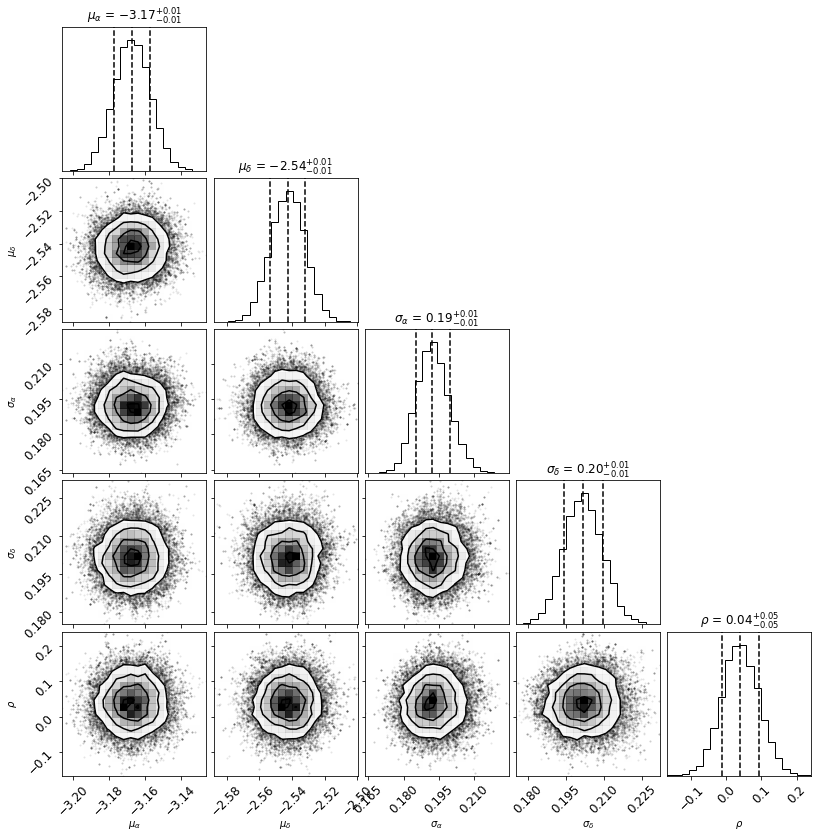

In [30]:
## using posterior1 without 1/sigma**2 prior

nwalkers = 50
ndim = 5

p0=np.zeros((nwalkers,ndim))
p0[:,0] = np.random.rand(nwalkers)-3.
p0[:,1] = np.random.rand(nwalkers)-3.
p0[:,2] = np.random.rand(nwalkers)*0.3
p0[:,3] = np.random.rand(nwalkers)*0.3
p0[:,4] = np.random.rand(nwalkers)*2.-1.

samples1 = mcmc_run(y, p0, lnlikeli = posterior1, ndim = ndim, nwalkers = nwalkers)

fig = corner.corner(samples1,\
            labels=[r"$\mu_\alpha$",r"$\mu_\delta$", r"$\sigma_\alpha$", r"$\sigma_\delta$",r"$\rho$"],\
            quantiles=[0.16, 0.5, 0.84],\
            show_titles=True, \
            title_kwargs={"fontsize": 12})

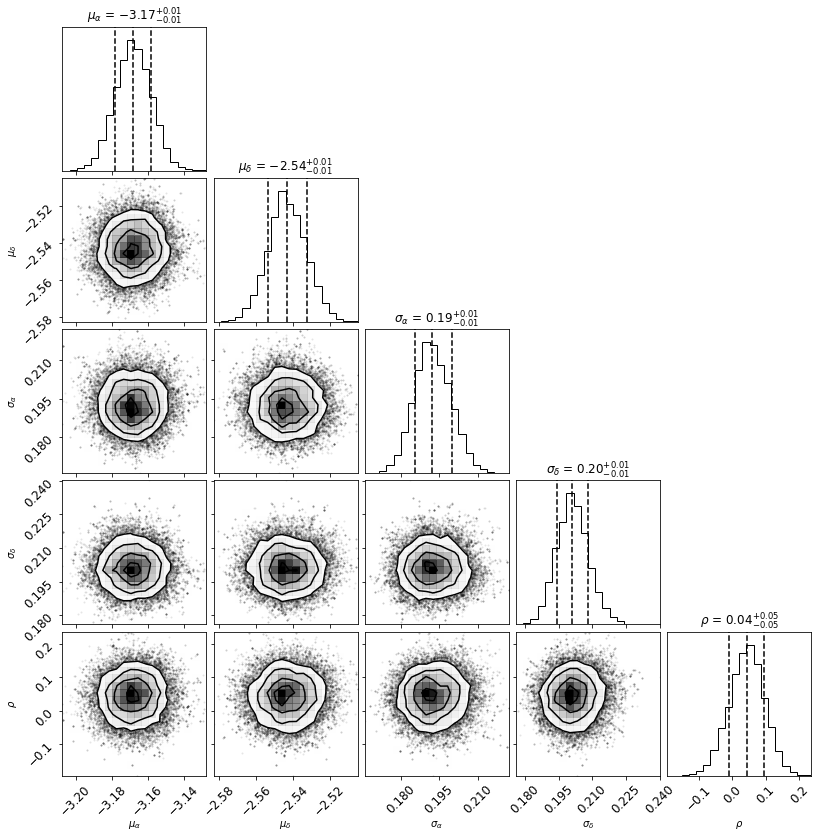

In [18]:
## using posterior2 with 1/sigma**2 prior

samples2 = mcmc_run(y, p0, lnlikeli = posterior2, ndim = ndim, nwalkers = nwalkers)

fig = corner.corner(samples2,\
            labels=[r"$\mu_\alpha$",r"$\mu_\delta$", r"$\sigma_\alpha$", r"$\sigma_\delta$",r"$\rho$"],\
            quantiles=[0.16, 0.5, 0.84],\
            show_titles=True, \
            title_kwargs={"fontsize": 12})